<a href="https://colab.research.google.com/github/henrigeuer/stratosphaerenflug/blob/main/strato_auswerung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Datenauswerung mit Python
Um zu beginnen, die einzelnen Codeabschnitte in ihrer Reihenfolge ausführen.

#Vorbereitung
Bevor die Daten grafisch dargestellt werden können, müssen sie zunächst vorbereitet werden. Aktuell befinden sie sich noch in Form von zwei CSV-Dateien. Nach diesem Abschnitt sollen sie als einzelne Listen für jede Messreihe vorliegen.

##Importieren der benötigten Bibliotheken
Die Bibliothek `matplotlib` soll verwendet werden, um die Daten darzustellen

In [50]:
import matplotlib.pyplot as plt

##Laden der Messwerte
Die Rohdaten der Datenlogger befinden sich im Github Reposotory. Von dort werden sie nun, zunächst als String, geladen.

In [2]:
#Laden des Github Repositories
!git clone https://github.com/henrigeuer/stratosphaerenflug.git

Cloning into 'stratosphaerenflug'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 44 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [3]:
#Speichern der Dateipfade
path_arduino = "/content/stratosphaerenflug/LOG.TXT"
path_strato = "/content/stratosphaerenflug/F_24.LOG"

#Öffnen der Dateien
file_arduino = open(path_arduino)
file_strato = open(path_strato)

#Zwischenpeichern der Daten
data_arduino = file_arduino.read()
data_strato = file_strato.read()

#Schließen der Dateien
file_arduino.close()
file_strato.close()

## Vorbereiten der Messwerte
Nun sollen alle gemessenen Daten in einzelne Listen gespeichert werden 

In [4]:
#Daten des Arduino
#Nach Zeilen trennen
data_arduino_rows = data_arduino.split("\n")
#Leere Zeilen entfernen
while "" in data_arduino_rows:
  data_arduino_rows.remove("")
#erste Zeile entfernen
data_arduino_rows.pop(0)

#Aufteilen jeder Zeile in einzelne Messwerte
data_arduino_elements =[]
for row in data_arduino_rows:
  data_arduino_elements.append(row.split(";"))


#Erstellen von Messwertspezifischen Listen
ino_temp = []
ino_hum = []
ino_press =[]
ino_tvoc= []
ino_co2 = []
ino_uv = []
for row in data_arduino_elements:
  ino_temp.append(float(row[0]))
  ino_hum.append(float(row[1]))
  ino_press.append(float(row[2])/100)
  ino_tvoc.append(float(row[3]))
  ino_co2.append(float(row[4]))
  ino_uv.append(float(row[5]))


In [5]:
#Daten des Strato3
#Nach Zeilen trennen
data_strato_rows = data_strato.split("\n")
#Leere Zeilen entfernen
while "" in data_strato_rows:
  data_strato_rows.remove("")

#erste zwei Zeilen entfernen
data_strato_rows.pop(0)
data_strato_rows.pop(0)

#Aufteilen jeder Zeile in einzelne Messwerte
data_strato_elements =[]
for row in data_strato_rows:
  data_strato_elements.append(row.split(";"))

#Erstellen von Messungsspezifischen listen
strato_speed = []
strato_course = []
strato_altitude =[]
strato_boardtemp= []
strato_temp = []
strato_hum = []
strato_press = []
strato_volt = []
for row in data_strato_elements:
  if row[9] =="NA" or row[9] == "":
    strato_speed.append(0)
  else:
    strato_speed.append(float(row[9]))

  if row[10] =="NA"or row[10] == "":
    strato_course.append(0)
  else:
    strato_course.append(float(row[10]))

  if row[11] =="NA"or row[11] == "":
    strato_altitude.append(0)
  else:
    strato_altitude.append(float(row[11]))

  if row[12] =="NA"or row[12] == "":
    strato_boardtemp.append(0)
  else:
    strato_boardtemp.append(float(row[12]))

  strato_temp.append(float(row[13]))
  strato_hum.append(float(row[14]))
  if row[15] =="Err":
    strato_press.append(0)
  else:
    strato_press.append(float(row[15]))

    strato_volt.append(float(row[16]))

#Zeitliste im Intervall 5sek erzeugen
time = []
i=0
while len(time)<2734:
  time.append(i)
  i+=5

## Steigrate berechnen

Die Steigrate wurde zwar nicht direkt aufgezeichnet, sie kann aber aus der Flughöhe berechnet werden

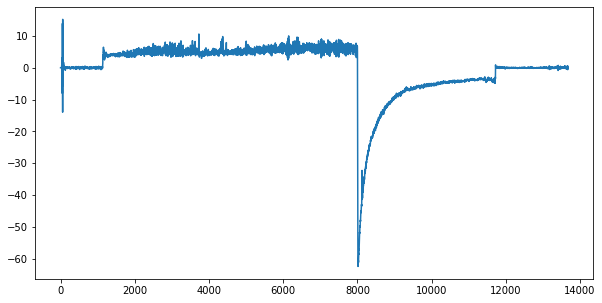

In [51]:
strato_steigrate = [0]
for k in range(1, len(strato_altitude)-1):
  m = (strato_altitude[k+1]-strato_altitude[k])/2
  strato_steigrate.append(m)

steigtime = []
i=0
while len(steigtime)<len(strato_steigrate):
  steigtime.append(i)
  i+=2

plt.plot(steigtime, strato_steigrate)
plt.show()

#Funktionen
Leider maßen beide Datenlogger in Unterschiedlichen Intervallen und für Unterschiedlich lange Zeiten. 
Um dieses Problem zu lösen benötigen wir noch zwei Funktion.
Zum Einen eine Funktion `twotofive`, die aus Messdaten im 2 Sekunden Intervall eine Liste mit Daten im 5 Sekunden Intervall berechnet. Dazu wird jeder 5. Wert übernommen und dazwischen je ein Mittelwert gebildet.



In [6]:
#Umrechnen in 5
def twotofive(liste):
  newlist= []
  for i in range(0,len(liste)-4,5):
    newlist.append(liste[i])
    value = (liste[i+2]+liste[i+3])/2
    newlist.append(value)
  return newlist




Außerdem wird eine Funktion `Liste_strecken` benötigt, die alle Listen  auf dieselbe Länge bringt, indem das erste und letzte Element vor- bzw. nach der Liste wiederholt wird. Der Parameter `faktor` gibt dabei an, in welchem Verhältnis die Anzahl der Elemente vor und nach der Liste stehen. Dadurch lassen sich die Messwerte entlang der x- Achse verschieben und somit die unterschiedlichen Start- und Endzeitpunkte ausgleichen.


In [ ]:
def liste_strecken(liste,faktor, refliste = time ):
  dif = len(refliste) - len(liste)
  pre = int(faktor*dif)
  after = dif-pre
  return [liste[0]]*(pre) +liste + [liste[-1]]*after

Einige der Messreihen enthalten noch Messfehler. Um diese zu bereinigen wird noch eine Funktion `clean` benötigt, die, wenn der Abstand zwischen zwei Punkten über einem Grenzwert `grenze` liegt, diesen Wert durch den Mittelwert des vorigen und folgenden Wertes ersetzt.

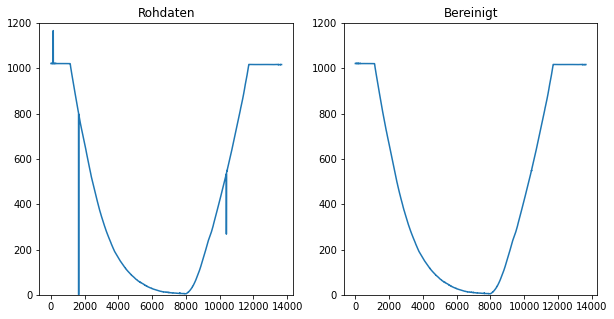

In [43]:
def clean(liste, grenze ):
  for i in range(1, len(liste)-1):
    dif = abs(liste[i]-liste[i-1])
    if dif> grenze:
      avg = (liste[i-1]+liste[i+1])/2
      liste[i] = avg
  
  return liste

# Ausprobieren
plt.rcParams["figure.figsize"] = (10, 5)
plt.subplot(1,2,1)
plt.ylim(0, 1200)
plt.title("Rohdaten")
plt.plot(time, twotofive(strato_press))

plt.subplot(1,2,2)
plt.ylim(0, 1200)
plt.title("Bereinigt")
plt.plot(time, clean(twotofive(strato_press), 10))
plt.show()

## Erste Graphen
Nun sind alle Messwerte und Funktionen vorbereitet, die für das Darstellen der Messwerte benötigt werden.
Beide Datenlogger haben den Luftdruck aufgezeichnet. Daher eignen sich diese Messwerte sehr gut, um den zeitlichen Versatz zwischen beiden Datenloggern einzustellen. Dazu muss nur der `faktor` der `liste_strecken`-Funktion so lange verändert werden, bis beide Graphen Deckungsgleich sind. `0.01`scheint ein passender Wert zu sein.

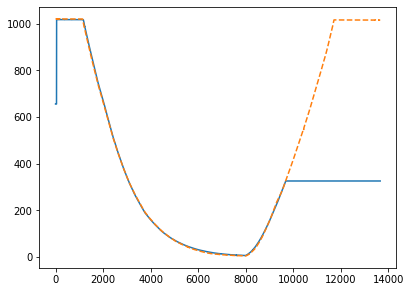

In [106]:
plt.rcParams["figure.figsize"] = (6.4,4.8)
plt.plot(time, liste_strecken(ino_press, 0.01))
plt.plot(time, clean(twotofive(strato_press),10),linestyle="--")
plt.show()

Der gewonnene Wert `0.01` kann als Standardwert an die Funktion übergeben werden

In [8]:
def liste_strecken(liste,faktor = 0.01,refliste = time ):
  dif = len(refliste) - len(liste)
  pre = int(faktor*dif)
  after = dif-pre
  return [liste[0]]*(pre) +liste + [liste[-1]]*after


## Platzhöhe/Zeitpunkt berechnen

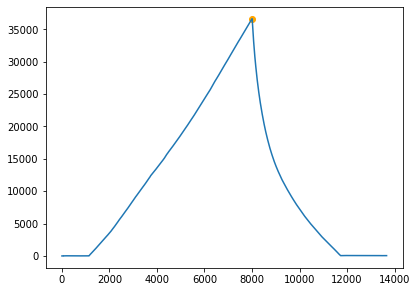

In [107]:

platzhoehe = max(twotofive(strato_altitude))
platzele = twotofive(strato_altitude).index(platzhoehe)
platztime = platzele*5

plt.plot(time, twotofive(strato_altitude))
#Punkt einzeichnen
plt.scatter(platztime, platzhoehe, color = "orange")
plt.show()

#Darstellung
Nun kann mit der grafischen Darstellung begonnen werden.
Folgende Messreihen stehen dabei zur Verfügung:
*   Zeit in s-> `time`
*   Außentemperatur(Arduino) in °C -> `ino_temp`
*   Außentemperatur(Strato3) in °C -> `strato_temp`
*   Innentemperatur(Strato3) in °C -> `strat_boardtemp`
*   Luftfeuchtigkeit(Arduino) in % -> `ino_hum`
*   Luftfeuchtigkeit(Strato3) in % -> `strato_hum`
*   Luftdruck(Arduino) in hP -> `ino_press`
*   Luftdruck(Strato3) in hP -> `strato_press`
*   TVOC-Wert(Arduino) -> `ino_tvoc`
*   CO2-Gehalt(Arduino) -> `ino_co2`
*   UV-Strahlung(Arduino) -> `ino_uv`
*   Geschwindigkeit(Strato3) in km/h -> `strato_speed`
*   Course over Ground(Strato3) -> `strato_course` (siehe: https://www.segeln-lernen.de/segellexikon-kurs-ueber-grund.html)
*   Flughöhe(Strato3) in m -> `strato_altitud`
*   Batteriespannung(Strato3) in V -> `strato_volt`
*   Steigrate(berechnet aus Strato3) in m/s -> `strato_steigrate`


Beispielhafter Aufbau

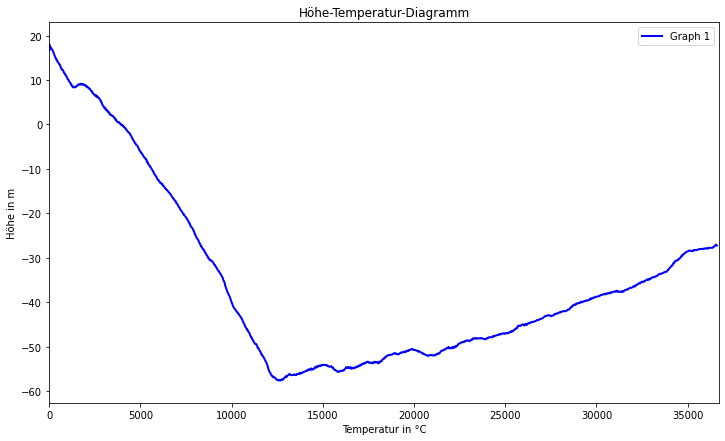

In [113]:
#Maße des Diagrammes
plt.rcParams["figure.figsize"] = (12,7)

#Diagrammtitel
plt.title("Höhe-Temperatur-Diagramm")

#Werte laden 
x = twotofive(strato_altitude)[:platzele]
y = twotofive(strato_temp)[:platzele]

#Achsenbeschriftung
plt.xlabel("Temperatur in °C")
plt.ylabel("Höhe in m")

#Wertebereich
plt.xlim(0, max(x)+100)
plt.ylim(min(y)-5, max(y)+5)

#Plot erstellen
plt.plot(x,y, color ="b", label = "Graph 1", linewidth=2, linestyle="-")

#Legende anlegen
plt.legend(loc= 0)



plt.show()
